In [20]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [21]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

In [22]:
DEVICE

'cuda'

In [23]:
%matplotlib inline

In [24]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='cifar_data', train=True, transform=transform, download=True)
valid_dataset = datasets.CIFAR10(root='cifar_data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [25]:
train_dataset[0][0].shape

torch.Size([3, 32, 32])

torch.Size([3, 32, 32]) 6


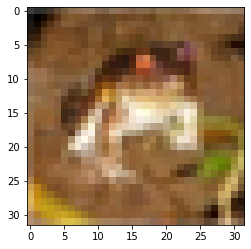

In [26]:
img, label = train_dataset[0]
print(img.shape, label)
img = img.numpy()

plt.imshow(img.transpose((1, 2, 0)))

In [27]:
def vggblock(in_channels, out_channels):
  block = nn.Sequential(
  nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
  nn.BatchNorm2d(out_channels),
  nn.ReLU())
  return block

In [31]:
class VGG(nn.Module):
  def __init__(self):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        vggblock(3, 64),
        nn.MaxPool2d(kernel_size=2, stride=2),
        vggblock(64, 128),
        nn.MaxPool2d(kernel_size=2, stride=2),
        vggblock(128, 256),
        vggblock(256, 256),
        nn.MaxPool2d(kernel_size=2, stride=2),
        vggblock(256, 512),
        vggblock(512, 512),
        nn.MaxPool2d(kernel_size=2, stride=2),
        vggblock(512, 512),
        vggblock(512, 512),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Linear(512, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(),
        nn.Linear(4096, 10)
    )


  def forward(self, X):
    X = self.feature_extractor(X)
    X = torch.flatten(X, 1)
    logits = self.classifier(X)
    probs = F.softmax(logits)
    return logits, probs

In [29]:
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for X, y in train_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)
  return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for X, y in valid_loader:
    optimizer.zero_grad()
    X = X.to(device)
    y = y.to(device)
    y_hat, _ = model(X)
    loss = criterion(y_hat, y)
    running_loss += loss.item() * X.size(0)

  epoch_loss = running_loss / len(valid_loader.dataset)
  return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device):
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  for epoch in range(0, epochs):
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    train_acc = get_accuracy(model, train_loader, device)
    valid_acc = get_accuracy(model, valid_loader, device)

    print(f'{datetime.now().time().replace(microsecond=0)} ---- '
          f'Epoch: {epoch}\t'
          f'Train Loss: {train_loss:.4f}\t'
          f'Valid Loss: {valid_loss:.4f}\t'
          f'Train Accuracy: {100 * train_acc:.2f}\t'
          f'Valid Accuracy: {100 * valid_acc:.2f}')
      
  plot_losses(train_losses, valid_losses)
  return model, optimizer, (train_losses, valid_losses)


def get_accuracy(model, data_loader, device):
  correct_pred = 0
  n = 0
  with torch.no_grad():
    model.eval()
    for X, y in data_loader:
      X = X.to(device)
      y = y.to(device)
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y.size(0)
      correct_pred += (y == predicted_labels).sum()

    return correct_pred.float()/n

def plot_losses(train_losses, valid_losses):
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig,ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(train_losses, color='blue', label='Training loss')
  ax.plot(valid_losses, color='red', label='Validation loss')
  ax.set(title='Loss over epochs',  xlabel='Epoch', ylabel='loss')
  ax.legend()
  fig.show()

  plt.style.use('default')

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


01:49:32 ---- Epoch: 0	Train Loss: 1.9543	Valid Loss: 1.8870	Train Accuracy: 21.64	Valid Accuracy: 21.53
01:50:08 ---- Epoch: 1	Train Loss: 1.6079	Valid Loss: 1.4667	Train Accuracy: 42.99	Valid Accuracy: 42.47
01:50:46 ---- Epoch: 2	Train Loss: 1.2564	Valid Loss: 1.5853	Train Accuracy: 47.78	Valid Accuracy: 47.03
01:51:23 ---- Epoch: 3	Train Loss: 0.9606	Valid Loss: 0.8513	Train Accuracy: 72.96	Valid Accuracy: 70.32
01:52:00 ---- Epoch: 4	Train Loss: 0.7852	Valid Loss: 0.9714	Train Accuracy: 70.73	Valid Accuracy: 67.53
01:52:38 ---- Epoch: 5	Train Loss: 0.6680	Valid Loss: 0.6645	Train Accuracy: 83.47	Valid Accuracy: 78.35
01:53:15 ---- Epoch: 6	Train Loss: 0.5676	Valid Loss: 0.6349	Train Accuracy: 85.56	Valid Accuracy: 79.16
01:53:52 ---- Epoch: 7	Train Loss: 0.4909	Valid Loss: 0.8639	Train Accuracy: 77.90	Valid Accuracy: 72.15
01:54:30 ---- Epoch: 8	Train Loss: 0.4087	Valid Loss: 0.6443	Train Accuracy: 88.61	Valid Accuracy: 79.77
01:55:07 ---- Epoch: 9	Train Loss: 0.3491	Valid Loss: 0

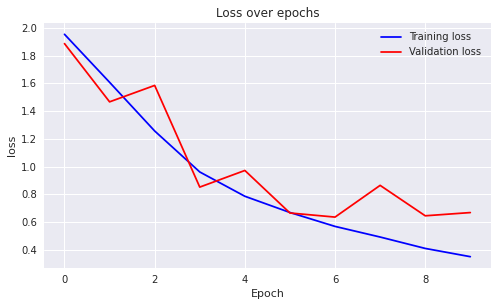

In [32]:
model = VGG()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, 10, DEVICE)